# Transfer Learning with Tensorflow Part 3

Our goal is to beat food 101 [original paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) with accuracy of 50.76% across 101 classes


In [ ]:
!nvidia-smi

Thu Jun 30 14:02:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## Creating helper functions

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2022-06-30 14:02:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-30 14:02:26 (97.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import *

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2022-06-30 14:02:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.114.128, 108.177.111.128, 142.250.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.114.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   132MB/s    in 9.8s    

2022-06-30 14:02:39 (158 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/waffles'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hummus'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/eggs_benedict'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caprese_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/churros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macaroni_and_cheese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_onion_soup'.
There are 0 directories and 75 

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                     label_mode="categorical",
                                                                     image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
checkpoint_path = "models/checkpoints/checkpoint_1"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2)
], name="data_augmentation")

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False


input_shape = (224, 224, 3)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="pooling")(x)
outputs = layers.Dense(len(train_data_all.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history = model.fit(train_data_all,
                    epochs=5,
                    validation_data=test_data,
                    validation_steps=int(0.15*len(test_data)),
                    callbacks=[create_tensorboard_callback("transfer_learning", "base_model"),
                               checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/base_model/20220630-140302
Epoch 1/5
237/237 [==============================] - 136s 498ms/step - loss: 3.4598 - accuracy: 0.2553 - val_loss: 2.6212 - val_accuracy: 0.4269
Epoch 2/5
237/237 [==============================] - 99s 416ms/step - loss: 2.3375 - accuracy: 0.4672 - val_loss: 2.1865 - val_accuracy: 0.4899
Epoch 3/5
237/237 [==============================] - 95s 399ms/step - loss: 1.9670 - accuracy: 0.5323 - val_loss: 2.0263 - val_accuracy: 0.4995
Epoch 4/5
237/237 [==============================] - 88s 372ms/step - loss: 1.7704 - accuracy: 0.5665 - val_loss: 1.9372 - val_accuracy: 0.5167
Epoch 5/5
237/237 [==============================] - 87s 366ms/step - loss: 1.6033 - accuracy: 0.6095 - val_loss: 1.8997 - val_accuracy: 0.5177


In [ ]:
evaluation_0 = model.evaluate(test_data)
evaluation_0

790/790 [==============================] - 59s 74ms/step - loss: 1.7165 - accuracy: 0.5534


[1.7165104150772095, 0.5533861517906189]

In [ ]:
for layer in base_model.layers[-5:]:
  layer.trainable=True

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])

model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>

In [ ]:
for i, layer in enumerate(model.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
fine_tune_epochs = 10

history_1 = model.fit(train_data_all,
                      epochs=fine_tune_epochs,
                      validation_data=test_data,
                      validation_steps=int(0.15*len(test_data)),
                      callbacks=[create_tensorboard_callback("transfer_learning", "model_1")],
                      initial_epoch=history.epoch[-1])

Saving TensorBoard log files to: transfer_learning/model_1/20220630-141309
Epoch 5/10
237/237 [==============================] - 54s 201ms/step - loss: 1.4338 - accuracy: 0.6574 - val_loss: 1.8987 - val_accuracy: 0.5159
Epoch 6/10
237/237 [==============================] - 47s 196ms/step - loss: 1.4240 - accuracy: 0.6614 - val_loss: 1.8940 - val_accuracy: 0.5151
Epoch 7/10
237/237 [==============================] - 44s 184ms/step - loss: 1.3900 - accuracy: 0.6721 - val_loss: 1.8942 - val_accuracy: 0.5122
Epoch 8/10
237/237 [==============================] - 42s 175ms/step - loss: 1.3822 - accuracy: 0.6702 - val_loss: 1.8932 - val_accuracy: 0.5117
Epoch 9/10
237/237 [==============================] - 40s 168ms/step - loss: 1.3627 - accuracy: 0.6764 - val_loss: 1.8809 - val_accuracy: 0.5156
Epoch 10/10
237/237 [==============================] - 40s 165ms/step - loss: 1.3616 - accuracy: 0.6735 - val_loss: 1.8901 - val_accuracy: 0.5135


In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 58s 73ms/step - loss: 1.6677 - accuracy: 0.5638


[1.667728304862976, 0.5638415813446045]

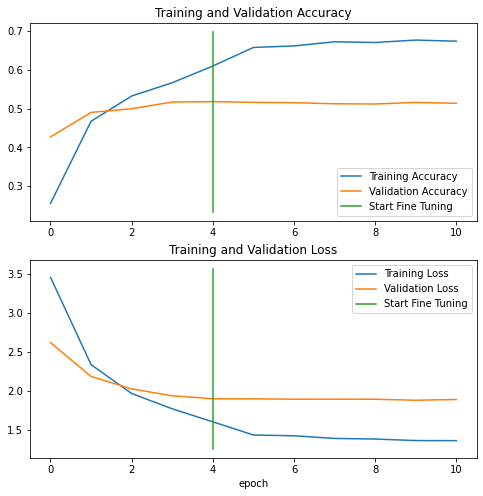

In [ ]:
compare_historys(original_history=history,
                 new_history=history_1,
                 initial_epochs=5)

In [ ]:
model.save("drive/MyDrive/tensorflow/og_model.h5")

In [ ]:
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow/og_model.h5")

In [ ]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 61s 75ms/step - loss: 1.6677 - accuracy: 0.5638


[1.667728304862976, 0.5638415813446045]

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-06-30 14:35:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 142.250.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   131MB/s    in 0.3s    

2022-06-30 14:35:00 (131 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
pre_trained_model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
pre_trained_model.evaluate(test_data)

790/790 [==============================] - 62s 77ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

In [ ]:
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 65s 81ms/step


In [ ]:
len(preds_probs)

25250

In [ ]:
tf.math.argmax(preds_probs, axis=1)[600]

<tf.Tensor: shape=(), dtype=int64, numpy=62>

In [ ]:
preds_probs[:10]

array([[2.4808551e-01, 3.3722125e-04, 1.7744279e-01, ..., 1.2662072e-03,
        5.4545123e-03, 2.0932091e-02],
       [8.3902192e-01, 9.0717067e-06, 4.2063324e-03, ..., 5.4804985e-03,
        2.4917177e-05, 5.0247851e-05],
       [1.2898223e-01, 3.5939335e-03, 1.3574876e-02, ..., 3.4255872e-03,
        3.6798296e-03, 3.4838896e-03],
       ...,
       [1.7937887e-01, 6.5444357e-05, 3.5609489e-03, ..., 2.6817773e-02,
        7.0403377e-04, 2.9398920e-04],
       [1.4292765e-01, 1.1581177e-03, 9.5408998e-02, ..., 1.5005869e-03,
        4.7886043e-04, 1.1844508e-03],
       [4.0260369e-01, 4.6088444e-05, 3.1256075e-03, ..., 1.6135383e-02,
        1.0933116e-04, 4.3621203e-03]], dtype=float32)

In [ ]:
tf.math.argmax(preds_probs[0])

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [ ]:
dir(test_data)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__debug_string__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__tf_tracing_type__',
 '__weakref__',
 '_abc_impl',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_apply_debug_options',
 '_as_serialized_graph',
 '_batch_size',
 '_checkpoint_dependencies',
 '_common_args',
 '_consumers',
 '_deferred_dependencies',
 '_deserialization_dependencies',
 '_deserialize_from_proto',
 '_drop_remainder',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_get_legacy_saved_model_children',
 '_graph',
 '_graph

In [ ]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels)

In [ ]:
y_labels[0]

<tf.Tensor: shape=(101,), dtype=float32, numpy=
array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

In [ ]:
y_labels = tf.math.argmax(y_labels, axis=1)

In [ ]:
len(y_labels)

25250

In [ ]:
y_labels[0]

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [ ]:
pred_classes = tf.math.argmax(preds_probs, axis=1)

In [ ]:
pred_classes[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([ 0,  0,  0, 38,  8, 78, 29, 46,  9,  0])>

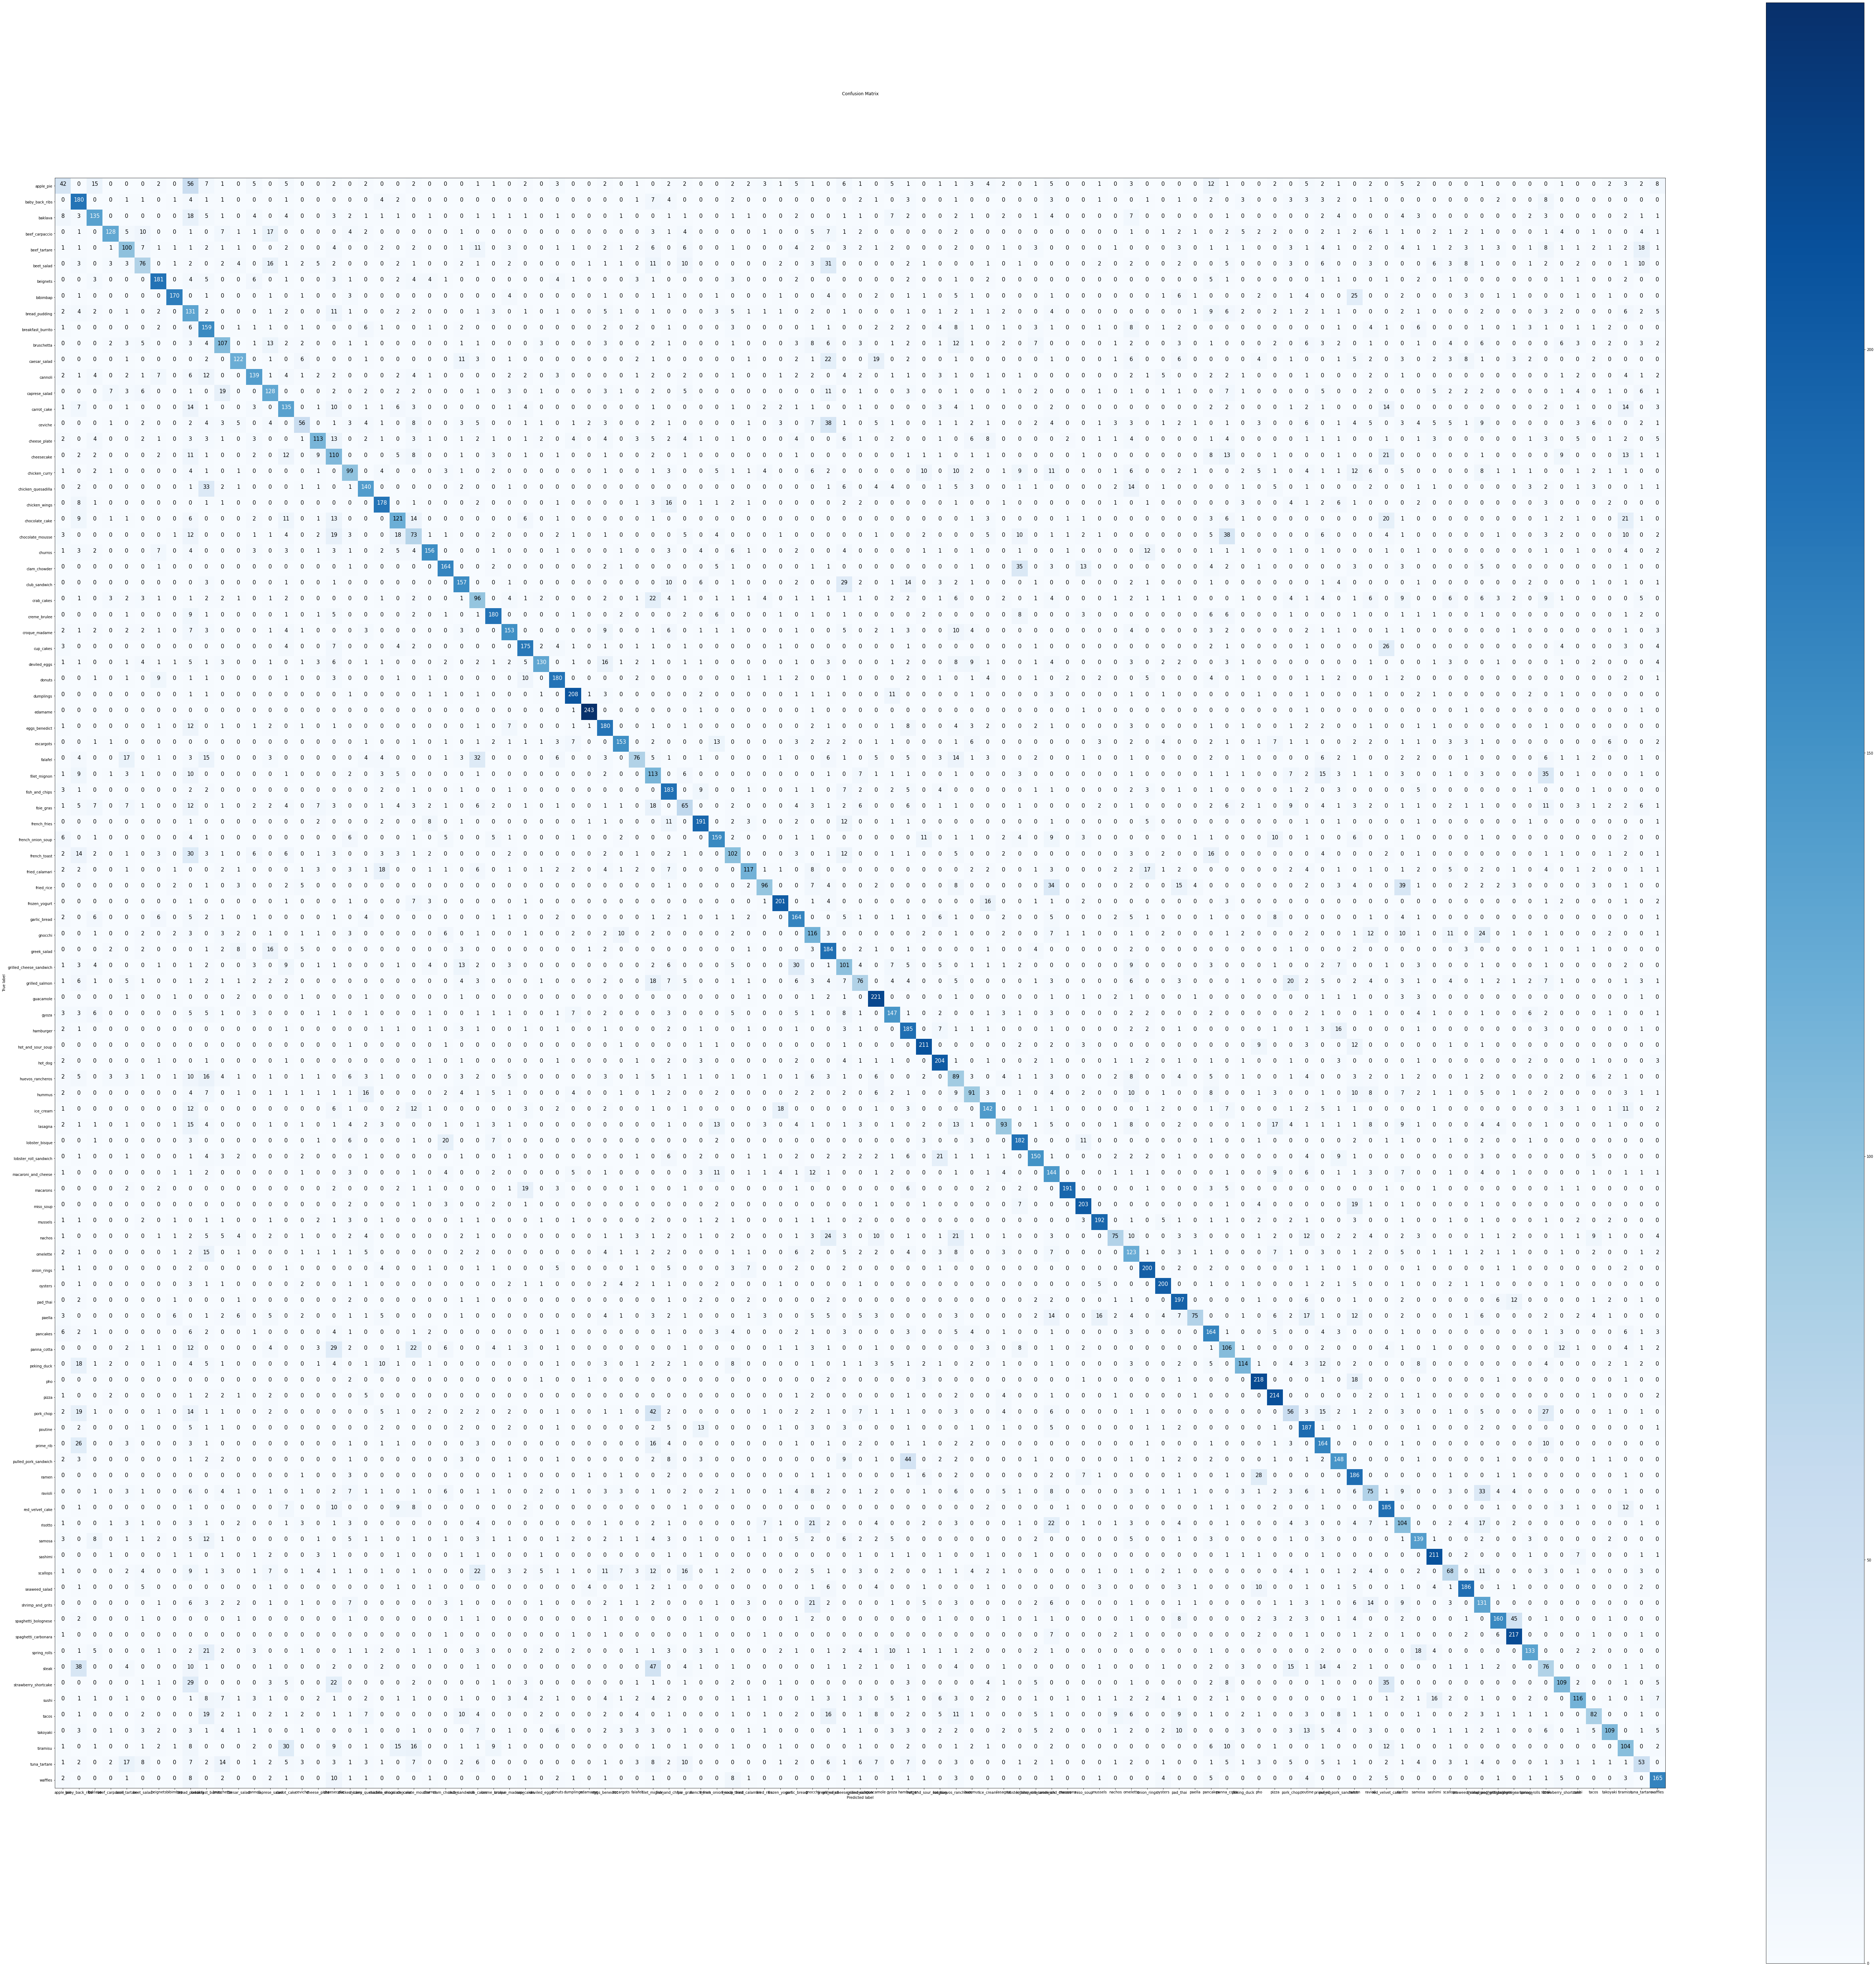

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100))

In [ ]:
class_names = test_data.class_names

In [ ]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
from sklearn.metrics import classification_report

cr = classification_report(y_true=y_labels,
                           y_pred=pred_classes)

In [ ]:
dir(cr)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmod__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'capitalize',
 'casefold',
 'center',
 'count',
 'encode',
 'endswith',
 'expandtabs',
 'find',
 'format',
 'format_map',
 'index',
 'isalnum',
 'isalpha',
 'isascii',
 'isdecimal',
 'isdigit',
 'isidentifier',
 'islower',
 'isnumeric',
 'isprintable',
 'isspace',
 'istitle',
 'isupper',
 'join',
 'ljust',
 'lower',
 'lstrip',
 'maketrans',
 'partition',
 'replace',
 'rfind',
 'rindex',
 'rjust',
 'rpartition',
 'rsplit',
 'rstrip',
 'split',
 'splitlines',
 'startswith',
 'strip',
 'swapcase',
 'title',
 'translate',
 'upper',


In [ ]:
print(cr)

              precision    recall  f1-score   support

           0       0.31      0.17      0.22       250
           1       0.44      0.72      0.55       250
           2       0.61      0.54      0.57       250
           3       0.79      0.51      0.62       250
           4       0.48      0.40      0.44       250
           5       0.48      0.30      0.37       250
           6       0.74      0.72      0.73       250
           7       0.87      0.68      0.76       250
           8       0.22      0.52      0.31       250
           9       0.37      0.64      0.47       250
          10       0.47      0.43      0.45       250
          11       0.68      0.49      0.57       250
          12       0.69      0.56      0.62       250
          13       0.50      0.51      0.51       250
          14       0.48      0.54      0.51       250
          15       0.50      0.22      0.31       250
          16       0.64      0.45      0.53       250
          17       0.32    

In [ ]:
class_names[33]

'edamame'